# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'VertebralColumn_c3'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([310, 6]), torch.Size([310]), 310, 6, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.3557, 0.5198, 0.2292, 0.2509, 0.3075, 0.0252],
        [0.1245, 0.2967, 0.0986, 0.1446, 0.4767, 0.0364],
        [0.4117, 0.5139, 0.3230, 0.3076, 0.3862, 0.0175],
        [0.4162, 0.5573, 0.2713, 0.2894, 0.3419, 0.0518],
        [0.2272, 0.2894, 0.1282, 0.2470, 0.4096, 0.0442],
        [0.1360, 0.3657, 0.0995, 0.1199, 0.6479, 0.0309],
        [0.2631, 0.4003, 0.2074, 0.2239, 0.5430, 0.0397],
        [0.1854, 0.3092, 0.1346, 0.1966, 0.5075, 0.0009],
        [0.1701, 0.3587, 0.2568, 0.1563, 0.5906, 0.0567],
        [0.1017, 0.2065, 0.2501, 0.1694, 0.1523, 0.0273]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(186, 62, 62)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Set random seed

In [11]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Normal NN

## Define

In [14]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, config.N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(config.N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
)

## Training

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=config.lr)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33871 | Loss: 1.187035680
| Epoch:   500 | Accuracy: 0.88710 | Loss: 0.445403278
| Epoch:  1000 | Accuracy: 0.87097 | Loss: 0.476967186
| Epoch:  1500 | Accuracy: 0.87097 | Loss: 0.491887510
| Epoch:  2000 | Accuracy: 0.87097 | Loss: 0.497199863
| Epoch:  2500 | Accuracy: 0.85484 | Loss: 0.498210341
| Epoch:  3000 | Accuracy: 0.85484 | Loss: 0.498514503
| Epoch:  3500 | Accuracy: 0.85484 | Loss: 0.508102834
| Epoch:  4000 | Accuracy: 0.85484 | Loss: 0.517315745
| Epoch:  4500 | Accuracy: 0.85484 | Loss: 0.532064974
| Epoch:  5000 | Accuracy: 0.85484 | Loss: 0.540939093
Early stop.
Finished.


(216, 0.43447259068489075)

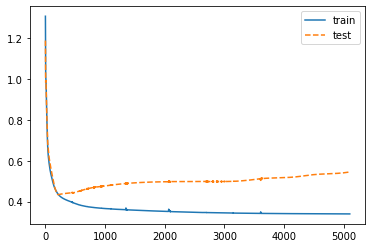

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [17]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.7580645161290323


In [18]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=6, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [19]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [20]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=config.lr)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   config.m, config.T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33871 | Loss: 0.856320500 |
| Epoch:   500 | Accuracy: 0.79032 | Loss: 0.365400672 |
| Epoch:  1000 | Accuracy: 0.87097 | Loss: 0.246119887 |
| Epoch:  1500 | Accuracy: 0.85484 | Loss: 0.217467055 |
| Epoch:  2000 | Accuracy: 0.85484 | Loss: 0.215274662 |
| Epoch:  2500 | Accuracy: 0.85484 | Loss: 0.213269413 |
| Epoch:  3000 | Accuracy: 0.85484 | Loss: 0.213063225 |
| Epoch:  3500 | Accuracy: 0.85484 | Loss: 0.212451130 |
| Epoch:  4000 | Accuracy: 0.87097 | Loss: 0.212060869 |
| Epoch:  4500 | Accuracy: 0.87097 | Loss: 0.211944774 |
| Epoch:  5000 | Accuracy: 0.87097 | Loss: 0.211877823 |
| Epoch:  5500 | Accuracy: 0.85484 | Loss: 0.213055298 |
| Epoch:  6000 | Accuracy: 0.85484 | Loss: 0.213927165 |
Early stop.
Finished.


(4954, 0.48874086141586304)

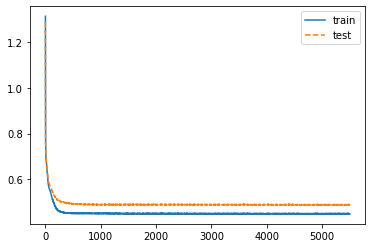

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [21]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [22]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.28927 | Loss: 1.060112476 |
| Epoch:     7 | Accuracy: 0.41871 | Loss: 0.875939310 |
| Epoch:    14 | Accuracy: 0.51040 | Loss: 0.759068012 |
| Epoch:    21 | Accuracy: 0.52887 | Loss: 0.720606565 |
| Epoch:    28 | Accuracy: 0.56565 | Loss: 0.699811220 |
| Epoch:    35 | Accuracy: 0.61895 | Loss: 0.619477093 |
| Epoch:    42 | Accuracy: 0.65508 | Loss: 0.556332707 |
| Epoch:    49 | Accuracy: 0.63726 | Loss: 0.616908491 |
| Epoch:    56 | Accuracy: 0.64234 | Loss: 0.584873021 |
| Epoch:    63 | Accuracy: 0.64702 | Loss: 0.588057637 |
| Epoch:    70 | Accuracy: 0.64847 | Loss: 0.556604266 |
| Epoch:    77 | Accuracy: 0.64040 | Loss: 0.587508023 |
| Epoch:    84 | Accuracy: 0.64484 | Loss: 0.565030456 |
| Epoch:    91 | Accuracy: 0.64661 | Loss: 0.567633450 |
| Epoch:    98 | Accuracy: 0.65782 | Loss: 0.577143192 |
| Epoch:   105 | Accuracy: 0.64815 | Loss: 0.570021093 |
| Epoch:   112 | Accuracy: 0.65032 | Loss: 0.582794964 |
| Epoch:   119 | Accuracy: 0.65

(148, 0.5154268145561218)

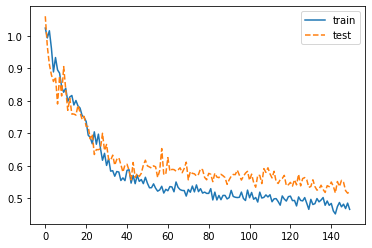

In [23]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [16]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57030 | Loss: 0.635289371 |
| Epoch:    12 | Accuracy: 0.57429 | Loss: 0.644272447 |
| Epoch:    24 | Accuracy: 0.57272 | Loss: 0.637918532 |
| Epoch:    36 | Accuracy: 0.57995 | Loss: 0.630374610 |
| Epoch:    48 | Accuracy: 0.56972 | Loss: 0.642033219 |
| Epoch:    60 | Accuracy: 0.56557 | Loss: 0.644615233 |
| Epoch:    72 | Accuracy: 0.57349 | Loss: 0.653560817 |
| Epoch:    84 | Accuracy: 0.56845 | Loss: 0.643557429 |
| Epoch:    96 | Accuracy: 0.58771 | Loss: 0.621717393 |
| Epoch:   108 | Accuracy: 0.56476 | Loss: 0.654738784 |
| Epoch:   120 | Accuracy: 0.55510 | Loss: 0.639820695 |
| Epoch:   132 | Accuracy: 0.56641 | Loss: 0.650432229 |
| Epoch:   144 | Accuracy: 0.58672 | Loss: 0.619448960 |
| Epoch:   156 | Accuracy: 0.57080 | Loss: 0.662978053 |
| Epoch:   168 | Accuracy: 0.57035 | Loss: 0.630398273 |
| Epoch:   180 | Accuracy: 0.56770 | Loss: 0.643987179 |
| Epoch:   192 | Accuracy: 0.57087 | Loss: 0.646285474 |
| Epoch:   204 | Accuracy: 0.59

(88, 0.6016548275947571)

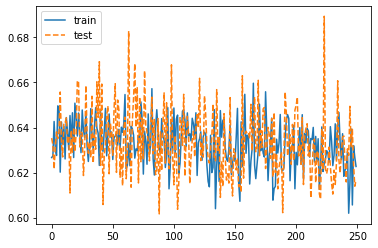

In [17]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [18]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57619 | Loss: 0.645039976 |
| Epoch:    12 | Accuracy: 0.57161 | Loss: 0.624958396 |
| Epoch:    24 | Accuracy: 0.57795 | Loss: 0.628694355 |
| Epoch:    36 | Accuracy: 0.56152 | Loss: 0.665233970 |
| Epoch:    48 | Accuracy: 0.56202 | Loss: 0.657961667 |
| Epoch:    60 | Accuracy: 0.57004 | Loss: 0.639231265 |
| Epoch:    72 | Accuracy: 0.57210 | Loss: 0.633881748 |
| Epoch:    84 | Accuracy: 0.57424 | Loss: 0.635161400 |
| Epoch:    96 | Accuracy: 0.54987 | Loss: 0.679967701 |
| Epoch:   108 | Accuracy: 0.57939 | Loss: 0.633888721 |
| Epoch:   120 | Accuracy: 0.56815 | Loss: 0.634072244 |
| Epoch:   132 | Accuracy: 0.57512 | Loss: 0.624881387 |
| Epoch:   144 | Accuracy: 0.56972 | Loss: 0.627275825 |
| Epoch:   156 | Accuracy: 0.58474 | Loss: 0.626327574 |
| Epoch:   168 | Accuracy: 0.56509 | Loss: 0.639849484 |
| Epoch:   180 | Accuracy: 0.58058 | Loss: 0.623205841 |
| Epoch:   192 | Accuracy: 0.57445 | Loss: 0.638708711 |
| Epoch:   204 | Accuracy: 0.58

(49, 0.596794068813324)

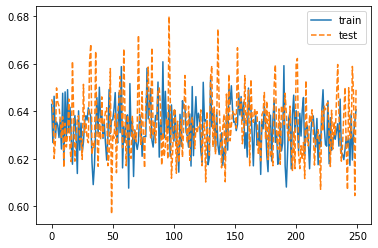

In [19]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [20]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)